# Visual Anomaly detection using Alibi detect

**About Alibi detect:**

Alibi Detect is an open source Python library focused on outlier, adversarial and drift detection. 
The package aims to cover both online and offline detectors for tabular data, text, 
images and time series. The outlier detection methods should allow the user to 
identify global, contextual and collective outliers.


In [1]:
#import regular libraries for utility functions
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.1


In [3]:
import alibi_detect

In [4]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image

In [17]:
img_dir = 'transistor/transistor/train/'
SIZE = 64
dataset = []
print(type(dataset))

<class 'list'>


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       131200    
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 512)         1049088   
                                                                 
 flatten_2003 (Flatten)      (None, 32768)             0         
                                                                 
 dense_14 (Dense)            (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_7"
_______________

None
Current threshold value is: 0.15
50/50 [=] - 50s 1s/step - loss_ma: -19779.3657
Current threshold value is: 0.15
Current threshold value is: 0.15


KeyError: 'instance'

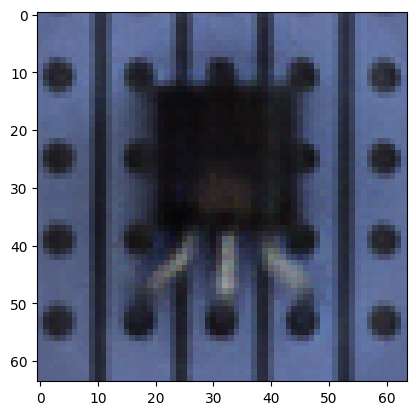

In [18]:
good_images = os.listdir(img_dir + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1]=='png'):
        image = cv2.imread(img_dir + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))
        
dataset = np.array(dataset)

train = dataset[0:200]
test = dataset[200:279]

train = train.astype('float32')/255
test = test.astype('float32')/255

#Let us also load bad image to verify our trained model
bad_images = os.listdir(img_dir + 'bad')
bad_dataset = []
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(img_dir + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32')/255

#####################################################################
# Define the encoder-decoder network for input to the OutlierVAE detector class.
# Can be any encoder and decoder

encoding_dim = 1024 #Dimension of the bottleneck encoder vector
dense_dim = [8,8,512] #Dimension of the last conv. output. This is used to work our way back in the decoder.

#Define encoder
encoder_net = tf.keras.Sequential(
[
    InputLayer(input_shape = train[0].shape),
    Conv2D(64, 4, strides = 2, padding = 'same', activation = tf.nn.relu),
    Conv2D(128, 4, strides = 2, padding = 'same', activation = tf.nn.relu),
    Conv2D(512, 4, strides = 2, padding = 'same', activation = tf.nn.relu),
    Flatten(),
    Dense(encoding_dim,)
])

print(encoder_net.summary())
#print(encoder_net.input_shape)

#Define the decoder.
#Start with the bottleneck dimension (encoder vector) and connect to dense layer
#with dim = total nodes in the last conv. in the encoder

decoder_net = tf.keras.Sequential(
[
    InputLayer(input_shape = (encoding_dim,)),
    Dense(np.prod(dense_dim)),
    Reshape(target_shape = dense_dim),
    Conv2DTranspose(256, 4, strides = 2, padding = 'same', activation = tf.nn.relu),
    Conv2DTranspose(64, 4, strides = 2, padding = 'same', activation = tf.nn.relu),
    Conv2DTranspose(3, 4, strides = 2, padding = 'same', activation = 'sigmoid')
])

print(decoder_net.summary())
#print(decoder_net.input_shape)

#####################################################################################
#Define and train the outlier detector.

latent_dim = 1024 #(Same as encoding dim.)

#intialize outlier detector
od = OutlierVAE(threshold = 0.15, #threshold for outlier score above which the element is flagged as an outlier.
               score_type = 'mse', #use MSE of reconstrution error for outlier detection
               encoder_net = encoder_net, #can also pass VAE model instead
               decoder_net = decoder_net, # of seprate encoder and decoder
               latent_dim = latent_dim,
               samples = 4)

print("Current threshold value is:", od.threshold)

#train
#from alibi_detect.models.tensorflow.losses import elbo #evidence lower bound loss

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
      optimizer = adam,
      epochs = 20,
      batch_size = 4,
      verbose = True)

#check thr threshold value.Should be the same as defined before
print("Current threshold value is:", od.threshold)

# infer_threshold Updates threshold by a value inferred from the precentage of
# instances considered top be outliers in a sample of the dataset.
# percentage of X considered to be normal based on the outlier score.
# Here, we set it to 99%

#od.infer_threshod( test, outlier_type = 'instance', threshold_perc = 99.0)
print("Current threshold value is:", od.threshold)



Is this image an outlier (0 for No and 1 for YES)? 1
Current threshold value is: 0.002
['instance_score', 'feature_score', 'is_outlier']


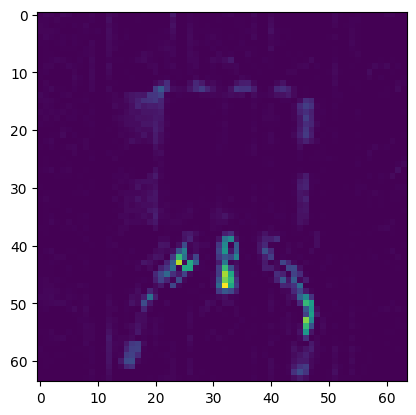

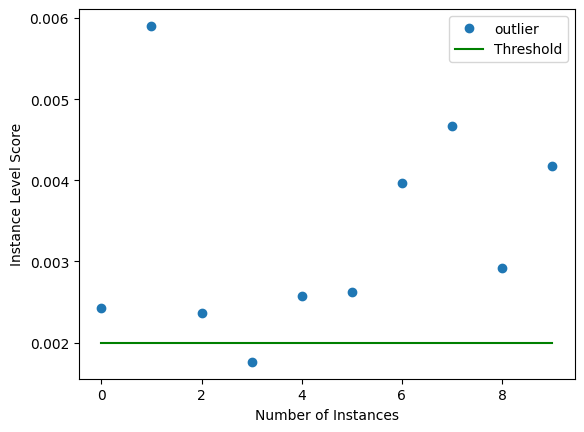

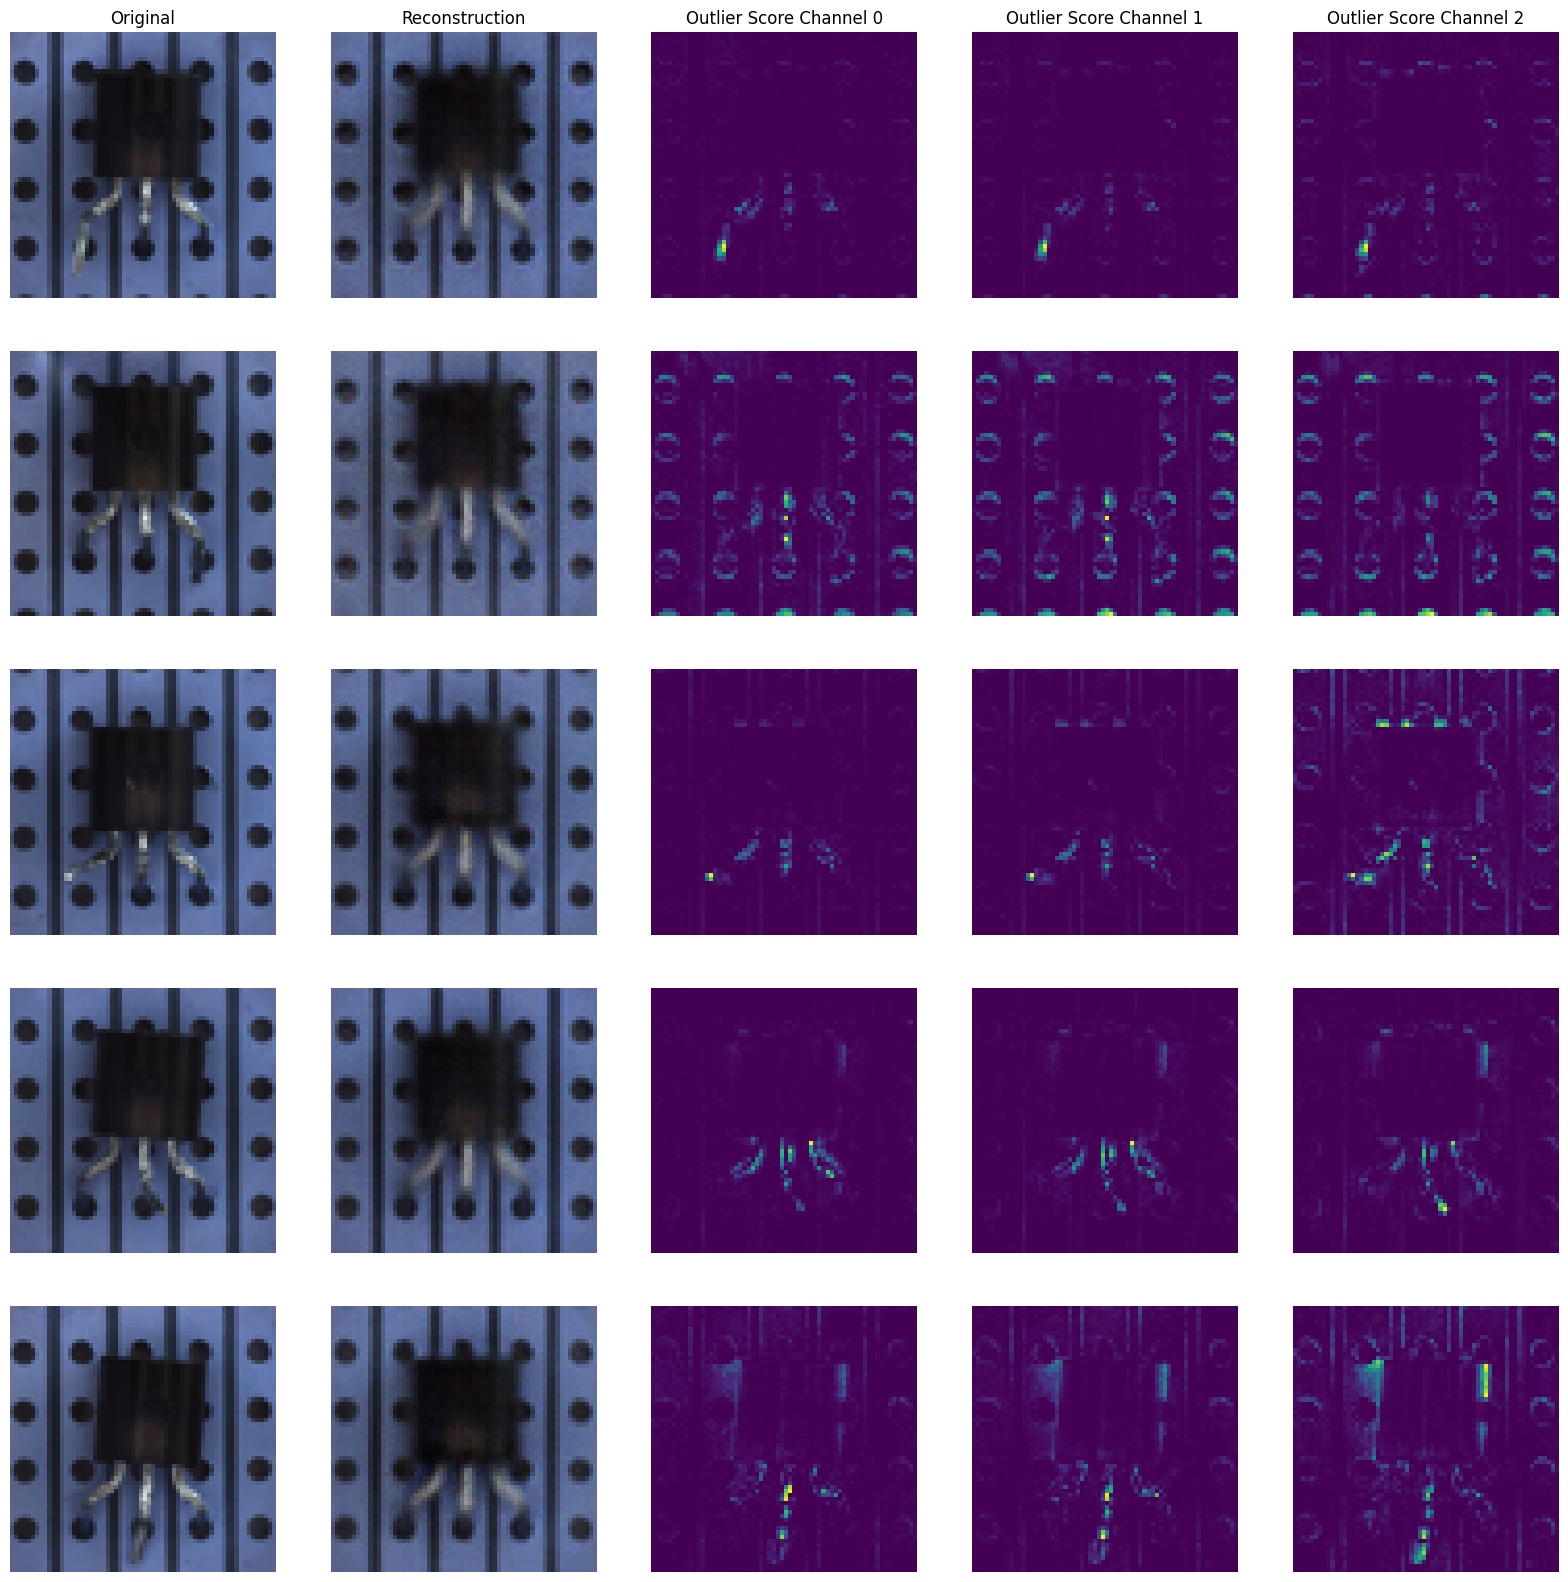

In [29]:
# save the trained outlier detector
#As mentioned in their documentation, save and load is having issues in python3.6 but works fine in 3.7
#from alibi_detect.utils import save_detector, load_detector  #If this does not work, try the next line
#from alibi_detect.utils.saving import save_detector, load_detector #Use this if the above line does not work. 
#save_detector(od, "saved_outlier_models/carpet_od_20epochs.h5")
#od = load_detector(filepath)

#Test our model on a bad image
img_num = 9
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #return a dictionary of data and metadata
#print(test_bad_image_predict)

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']
#print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for No and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])

#You can also manually define the threshold based on your specific use case.
od.threshold = 0.002
print("Current threshold value is:", od.threshold)

#Let us check it for multiple images
X = bad_dataset[:20]

od_preds = od.predict(X,
                      outlier_type = 'instance', #use 'feature' or 'instance' level
                      return_feature_score = True , #scores used to detemine outlier
                      return_instance_score = True
                     )

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores.using the built-in function for the scatterplot
target = np.ones(X.shape[0],).astype(int) #ground truth(all ones for bad images)
labels = ['normal','outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

#plot features for select images, using the buit in fucction(plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                          X,
                          X_recon = X_recon)
                           #instnace_ids = [0, 5, 10, 15, 17], #pass a list with indices of instances to display
                           #max_instance = 5, #max nb of instances to display
                           #outlier_only = False) #only show outlier predictions

In [13]:
alibi_detect.od.__all__

['OutlierAEGMM',
 'IForest',
 'Mahalanobis',
 'OutlierAE',
 'OutlierVAE',
 'OutlierVAEGMM',
 'OutlierSeq2Seq',
 'SpectralResidual',
 'LLR',
 'OutlierProphet']

In [14]:
from alibi_detect.od import OutlierVAE

In [15]:
od = OutlierVAE(
    threshold=0.1,
    encoder_net=encoder_net,
    decoder_net=decoder_net,
    latent_dim=1024
)